In [1]:
import shutil

import tweepy
import os
import re
import string

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import multiprocessing

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.ops import string_ops
from tensorflow.python.util.tf_export import keras_export

from pathlib import Path


In [2]:
# 학습 시작
print("Start learning...")

# 원본: 텐서플로우 GitHub
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/preprocessing/text_dataset.py


def index_directory(directory,
                    labels,
                    formats,
                    class_names=None,
                    shuffle=True,
                    seed=None,
                    follow_links=False):
    inferred_class_names = []
    for subdir in sorted(os.listdir(directory)):
        if os.path.isdir(os.path.join(directory, subdir)):
            inferred_class_names.append(subdir)
    if not class_names:
        class_names = inferred_class_names
    else:
        if set(class_names) != set(inferred_class_names):
            raise ValueError(
                'The `class_names` passed did not match the '
                'names of the subdirectories of the target directory. '
                'Expected: %s, but received: %s' %
                (inferred_class_names, class_names))
    class_indices = dict(zip(class_names, range(len(class_names))))

    pool = multiprocessing.pool.ThreadPool()
    results = []
    filenames = []
    for dirpath in (os.path.join(directory, subdir) for subdir in class_names):
        results.append(
            pool.apply_async(index_subdirectory,
                             (dirpath, class_indices, follow_links, formats)))
    labels_list = []
    for res in results:
        partial_filenames, partial_labels = res.get()
        labels_list.append(partial_labels)
        filenames += partial_filenames
    if labels != 'inferred':
        if len(labels) != len(filenames):
            raise ValueError('Expected the lengths of `labels` to match the number '
                             'of files in the target directory. len(labels) is %s '
                             'while we found %s files in %s.' % (
                                 len(labels), len(filenames), directory))
    else:
        i = 0
        labels = np.zeros((len(filenames),), dtype='int32')
        for partial_labels in labels_list:
            labels[i:i + len(partial_labels)] = partial_labels
            i += len(partial_labels)

    print('Found %d files belonging to %d classes.' %
          (len(filenames), len(class_names)))
    pool.close()
    pool.join()
    file_paths = [os.path.join(directory, fname) for fname in filenames]

    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(file_paths)
        rng = np.random.RandomState(seed)
        rng.shuffle(labels)
    return file_paths, labels, class_names


def iter_valid_files(directory, follow_links, formats):
    walk = os.walk(directory, followlinks=follow_links)
    for root, _, files in sorted(walk, key=lambda x: x[0]):
        for fname in sorted(files):
            if fname.lower().endswith(formats):
                yield root, fname


def index_subdirectory(directory, class_indices, follow_links, formats):
    dirname = os.path.basename(directory)
    valid_files = iter_valid_files(directory, follow_links, formats)
    labels = []
    filenames = []
    for root, fname in valid_files:
        labels.append(class_indices[dirname])
        absolute_path = os.path.join(root, fname)
        relative_path = os.path.join(
            dirname, os.path.relpath(absolute_path, directory))
        filenames.append(relative_path)
    return filenames, labels


def check_validation_split_arg(validation_split, subset, shuffle, seed):
    if validation_split and not 0 < validation_split < 1:
        raise ValueError(
            '`validation_split` must be between 0 and 1, received: %s' %
            (validation_split,))
    if (validation_split or subset) and not (validation_split and subset):
        raise ValueError(
            'If `subset` is set, `validation_split` must be set, and inversely.')
    if subset not in ('training', 'validation', None):
        raise ValueError('`subset` must be either "training" '
                         'or "validation", received: %s' % (subset,))
    if validation_split and shuffle and seed is None:
        raise ValueError(
            'If using `validation_split` and shuffling the data, you must provide '
            'a `seed` argument, to make sure that there is no overlap between the '
            'training and validation subset.')


def get_training_or_validation_split(samples, labels, validation_split, subset):
    if not validation_split:
        return samples, labels

    num_val_samples = int(validation_split * len(samples))
    if subset == 'training':
        print('Using %d files for training.' %
              (len(samples) - num_val_samples,))
        samples = samples[:-num_val_samples]
        labels = labels[:-num_val_samples]
    elif subset == 'validation':
        print('Using %d files for validation.' % (num_val_samples,))
        samples = samples[-num_val_samples:]
        labels = labels[-num_val_samples:]
    else:
        raise ValueError('`subset` must be either "training" '
                         'or "validation", received: %s' % (subset,))
    return samples, labels


def labels_to_dataset(labels, label_mode, num_classes):
    label_ds = dataset_ops.Dataset.from_tensor_slices(labels)
    if label_mode == 'binary':
        label_ds = label_ds.map(
            lambda x: array_ops.expand_dims(math_ops.cast(x, 'float32'), axis=-1))
    elif label_mode == 'categorical':
        label_ds = label_ds.map(lambda x: array_ops.one_hot(x, num_classes))
    return label_ds


def paths_and_labels_to_dataset(file_paths,
                                labels,
                                label_mode,
                                num_classes,
                                max_length):
    path_ds = dataset_ops.Dataset.from_tensor_slices(file_paths)
    string_ds = path_ds.map(
        lambda x: path_to_string_content(x, max_length))
    if label_mode:
        label_ds = labels_to_dataset(labels, label_mode, num_classes)
        string_ds = dataset_ops.Dataset.zip((string_ds, label_ds))
    return string_ds


def path_to_string_content(path, max_length):
    txt = io_ops.read_file(path)
    if max_length is not None:
        txt = string_ops.substr(txt, 0, max_length)
    return txt


def text_dataset_from_directory(directory,
                                labels='inferred',
                                label_mode='int',
                                class_names=None,
                                batch_size=32,
                                max_length=None,
                                shuffle=True,
                                seed=None,
                                validation_split=None,
                                subset=None,
                                follow_links=False):
    if labels != 'inferred':
        if not isinstance(labels, (list, tuple)):
            raise ValueError(
                '`labels` argument should be a list/tuple of integer labels, of '
                'the same size as the number of text files in the target '
                'directory. If you wish to infer the labels from the subdirectory '
                'names in the target directory, pass `labels="inferred"`. '
                'If you wish to get a dataset that only contains text samples '
                '(no labels), pass `labels=None`.')
        if class_names:
            raise ValueError('You can only pass `class_names` if the labels are '
                             'inferred from the subdirectory names in the target '
                             'directory (`labels="inferred"`).')
    if label_mode not in {'int', 'categorical', 'binary', None}:
        raise ValueError(
            '`label_mode` argument must be one of "int", "categorical", "binary", '
            'or None. Received: %s' % (label_mode,))
    if seed is None:
        seed = np.random.randint(1e6)
    check_validation_split_arg(
        validation_split, subset, shuffle, seed)

    file_paths, labels, class_names = index_directory(
        directory,
        labels,
        formats=('.txt',),
        class_names=class_names,
        shuffle=shuffle,
        seed=seed,
        follow_links=follow_links)

    if label_mode == 'binary' and len(class_names) != 2:
        raise ValueError(
            'When passing `label_mode="binary", there must exactly 2 classes. '
            'Found the following classes: %s' % (class_names,))

    file_paths, labels = get_training_or_validation_split(
        file_paths, labels, validation_split, subset)

    dataset = paths_and_labels_to_dataset(
        file_paths=file_paths,
        labels=labels,
        label_mode=label_mode,
        num_classes=len(class_names),
        max_length=max_length)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset.class_names = class_names
    return dataset

Start learning...


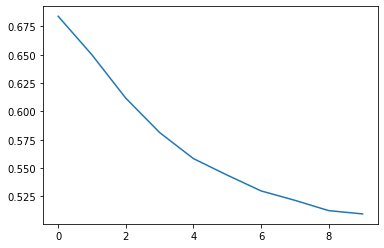

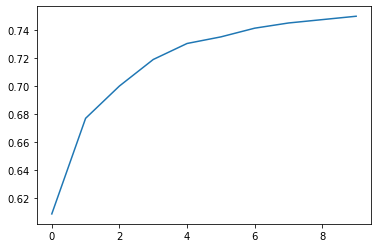

In [6]:
loss = [0.6840, 0.6499, 0.6117, 0.5814, 0.5584, 0.5438, 0.5299, 0.5216, 0.5125, 0.5096]
accuracy = [0.6090, 0.6771, 0.7001, 0.7190, 0.7304, 0.7351, 0.7413, 0.7450, 0.7474, 0.7498]

plt.figure()
plt.plot(loss)
plt.show()
plt.plot(accuracy)
plt.show()